Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 3)]                  0         []                            
                                                                                                  
 dense (Dense)               (None, 128)                  512       ['input_1[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 64)                   8256      ['dense[0][0]']               
                                                                                                  
 dense_2 (Dense)             (None, 1)                    65        ['dense_1[0][0]']             
                                                                                              

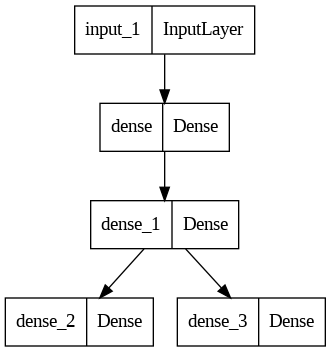

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Functional API Demo

from keras.models import Model

from keras.layers import *

x = Input(shape=(3,))

hidden1 = Dense(128,activation='relu')(x)
hidden2 = Dense(64,activation='relu')(hidden1)

output1 = Dense(1,activation='linear')(hidden2)
output2 = Dense(1,activation='sigmoid')(hidden2)

model = Model(inputs =x, outputs = [output1,output2] )

model.summary()

from keras.utils import plot_model

plot_model(model)



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 32)]                 0         []                            
                                                                                                  
 dense_6 (Dense)             (None, 64)                   8256      ['input_3[0][0]']             
                                                                                                  
 dense_4 (Dense)             (None, 8)                    264       ['input_2[0][0]']             
                                                                                            

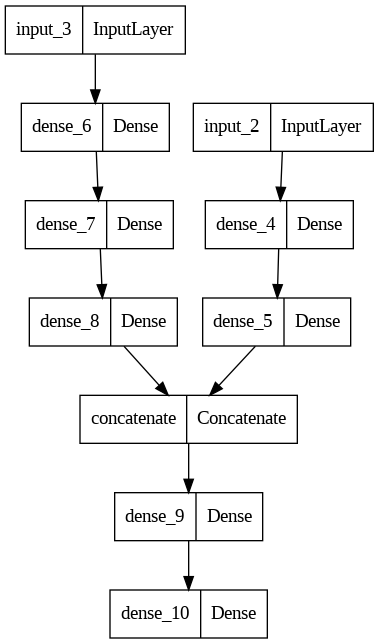

In [ ]:
#  2- Input and 1- Output

inputA = Input(shape=(32,))
inputB = Input(shape=(128,))

x = Dense(8,activation='relu')(inputA)
x1 = Dense(4,activation='relu')(x)

y = Dense(64,activation='relu')(inputB)
y1 = Dense(32,activation='relu')(y)
y2 = Dense(4,activation='relu')(y1)

combined = concatenate([x1,y2])

z = Dense(2,activation='relu')(combined)
z1 = Dense(1,activation='relu')(z)

model = Model(inputs=[inputA,inputB],outputs=[z1])

model.summary()

from keras.utils import plot_model

plot_model(model)

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d jangedoo/utkface-new

100% 330M/331M [00:05<00:00, 20.5MB/s]
100% 331M/331M [00:05<00:00, 65.4MB/s]


In [ ]:
import zipfile
zip = zipfile.ZipFile('/content/utkface-new.zip')
zip.extractall('/content')
zip.close()

In [ ]:
import os
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
folder_path = '/content/utkface_aligned_cropped/UTKFace'

In [ ]:
age = []
gender = []
img_path = []
for file in os.listdir(folder_path):
  age.append(int(file.split('_')[0]))
  gender.append(int(file.split('_')[1]))
  img_path.append(file)

In [ ]:
len(age)

23708

In [ ]:


df = pd.DataFrame({'age':age,'gender':gender,'img_path':img_path})

In [ ]:
df.shape

(23708, 3)

In [ ]:

df.head()

,age,gender,img_path
0,32,1,32_1_0_20170112235000656.jpg.chip.jpg
1,1,0,1_0_2_20161219195848259.jpg.chip.jpg
2,2,0,2_0_2_20161219190009084.jpg.chip.jpg
3,46,0,46_0_0_20170113181514861.jpg.chip.jpg
4,89,0,89_0_1_20170116024131102.jpg.chip.jpg


In [ ]:
train_df = df.sample(frac=1,random_state=0).iloc[:20000]
test_df = df.sample(frac=1,random_state=0).iloc[20000:]

In [ ]:
train_df.shape

(20000, 3)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range = 30,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    rescale = 1./255
)

In [ ]:
# flow_from_((dataframe))
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    directory=folder_path,
                                                    x_col='img_path',
                                                    y_col=['age','gender'],
                                                    target_size=(200,200),
                                                    class_mode='multi_output')

test_generator = test_datagen.flow_from_dataframe(test_df,
                                                    directory=folder_path,
                                                    x_col='img_path',
                                                    y_col=['age','gender'],
                                                    target_size=(200,200),
                                                  class_mode='multi_output')

Found 20000 validated image filenames.
Found 3708 validated image filenames.


In [ ]:
from keras.applications.resnet50 import ResNet50
from keras.layers import *
from keras.models import Model

In [ ]:
resnet = ResNet50(include_top=False,input_shape=(200,200,3))

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
resnet.trainable=False

In [ ]:
output = resnet.layers[-1].output

flatten = Flatten()(output)

dense1 = Dense(512,activation='relu')(flatten)
dense2 = Dense(512,activation='relu')(flatten)

dense3 = Dense(512,activation='relu')(dense1)
dense4 = Dense(512,activation='relu')(dense2)

output1 = Dense(1,activation='linear',name='age')(dense3)
output2 = Dense(1,activation='sigmoid',name='gender')(dense4)

In [ ]:
model = Model(inputs = resnet.input , outputs = [output1,output2])

In [ ]:
model.compile(optimizer='adam' , loss = {'age':'mse','gender':'binary_crossentropy'} , metrics = {'age':'mae','gender':'accuracy'}, loss_weights= {'age':1,'gender':99})

In [ ]:
model.fit(train_generator, batch_size=32, epochs=10, validation_data=test_generator)

Epoch 1/10
625/625 [==============================] - 252s 384ms/step - loss: 500.1753 - age_loss: 414.9380 - gender_loss: 0.8610 - age_mae: 15.7261 - gender_accuracy: 0.5125 - val_loss: 461.9040 - val_age_loss: 393.3736 - val_gender_loss: 0.6922 - val_age_mae: 14.9047 - val_gender_accuracy: 0.5286
Epoch 2/10
625/625 [==============================] - 236s 378ms/step - loss: 460.2416 - age_loss: 391.6738 - gender_loss: 0.6926 - age_mae: 15.2919 - gender_accuracy: 0.5217 - val_loss: 461.7961 - val_age_loss: 393.3351 - val_gender_loss: 0.6915 - val_age_mae: 16.0902 - val_gender_accuracy: 0.5286
Epoch 3/10
625/625 [==============================] - 238s 381ms/step - loss: 451.5182 - age_loss: 382.9802 - gender_loss: 0.6923 - age_mae: 15.1077 - gender_accuracy: 0.5217 - val_loss: 424.2119 - val_age_loss: 355.7395 - val_gender_loss: 0.6916 - val_age_mae: 14.6586 - val_gender_accuracy: 0.5286
Epoch 4/10
625/625 [==============================] - 237s 379ms/step - loss: 446.7411 - age_loss: 3